In [1]:
import os
import sys
import sqlite3
from dotenv import load_dotenv
import importlib.metadata

# Project root
project_root = os.path.abspath("..")
sys.path.append(project_root)

# Load environment variables
load_dotenv(os.path.join(project_root, ".env"))

True

In [2]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth

scope = (
    "playlist-read-private "
    "playlist-modify-private "
    "playlist-modify-public "
    "user-library-read "
    "user-read-recently-played"
)

cache_path = os.path.join(project_root, ".spotify_cache")

sp = spotipy.Spotify(
    auth_manager=SpotifyOAuth(
        scope=scope,
        cache_path=cache_path
    )
)

print("Spotify authenticated.")
print("Current user:", sp.current_user()["id"])
print("Spotipy version:", importlib.metadata.version("spotipy"))

Spotify authenticated.
Current user: 21ogollmd4ljapwluvwxe3stq
Spotipy version: 2.25.2


In [3]:
from core.database import get_connection, create_tables, get_latest_added_at
from core.ingestion import sync_new_tracks

db_path = os.path.join(project_root, "music_agent.db")

conn = get_connection(db_path)
create_tables(conn)

print("Database connected.")
print("SQLite version:", sqlite3.sqlite_version)

cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print("Tables:", cursor.fetchall())

# Sync saved tracks
new_tracks = sync_new_tracks(sp, conn, get_latest_added_at)
print("New tracks inserted:", new_tracks)

cursor.execute("SELECT COUNT(*) FROM tracks;")
print("Total tracks:", cursor.fetchone()[0])

Database connected.
SQLite version: 3.45.3
Tables: [('tracks',), ('artists',), ('albums',), ('track_artists',), ('track_albums',), ('playlists',), ('playlist_tracks',), ('saved_albums',), ('track_audio_features',), ('track_metrics',), ('playlist_metrics',), ('play_history',), ('sqlite_sequence',)]
New tracks inserted: 0
Total tracks: 727


In [4]:
from core.db_session import DatabaseSession
from core.repository import Repository
from core.behavior import ingest_recently_played

db_session = DatabaseSession(db_path)
repo = Repository(db_session)

# Ingest recently played behavior (ya usa repo)
inserted = ingest_recently_played(sp, repo, limit=50)
print("Inserted real play events:", inserted)

print("Total play_history rows:", repo.get_recently_played_track_names(limit=1000))

Inserted real play events: 40
Total play_history rows: ['Do It Better (feat. Zoe Wees)', 'Do It Better (feat. Zoe Wees)', 'Do It Better (feat. Zoe Wees)', 'Do It Better (feat. Zoe Wees)', 'Do It Better (feat. Zoe Wees)', 'Do It Better (feat. Zoe Wees)', 'Do It Better (feat. Zoe Wees)', 'Do It Better (feat. Zoe Wees)', 'Do It Better (feat. Zoe Wees)', 'Do It Better (feat. Zoe Wees)', 'Do It Better (feat. Zoe Wees)', 'Ascend', 'Ascend', 'Ascend', 'Ascend', 'Ascend', 'Ascend', 'Ascend', 'Ascend', 'Ascend', 'Ascend', 'Ascend', 'Location', 'Location', 'Location', 'Location', 'Location', 'Location', 'Location', 'Location', 'Location', 'Location', 'Location', 'Fantaisie-Impromptu in C-Sharp Minor, Op. 66', 'Fantaisie-Impromptu in C-Sharp Minor, Op. 66', 'Fantaisie-Impromptu in C-Sharp Minor, Op. 66', 'Fantaisie-Impromptu in C-Sharp Minor, Op. 66', 'Fantaisie-Impromptu in C-Sharp Minor, Op. 66', 'Fantaisie-Impromptu in C-Sharp Minor, Op. 66', 'Fantaisie-Impromptu in C-Sharp Minor, Op. 66', 'Fa

In [5]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0
)

In [ ]:
from core.graph.builder import build_music_graph

# Asegúrate de tener llm inicializado antes
graph = build_music_graph(repo, sp, llm)

print("Graph compiled successfully.")

In [6]:
from core.graph.builder import build_music_graph

In [7]:
graph = build_music_graph(repo, sp, llm)
print(graph)

In [ ]:
state = {
    "user_input": "Create a playlist with my top played songs this month",
    "strategy": None,
    "result_tracks": None,
    "error": None,
    "needs_clarification": False,
    "clarification_message": None,
    "confirmed": False,
    "intent": "build"
}

from core.graph.nodes import strategy_node

test = strategy_node(state, llm)
test["strategy"]

In [ ]:
state = {
    "user_input": "Create a playlist with my top played songs this month",
    "strategy": None,
    "result_tracks": None,
    "error": None,
    "needs_clarification": False,
    "clarification_message": None,
    "confirmed": False,
    "intent": "build"
}

from core.graph.nodes import strategy_node

test = strategy_node(state, llm)
test["strategy"]

In [ ]:
result = graph.invoke({
    "user_input": "Create a playlist with my top played songs this month",
    "strategy": None,
    "result_tracks": None,
    "error": None,
    "needs_clarification": False,
    "clarification_message": None,
    "confirmed": False,
    "intent": ""
})

result

In [ ]:
result["confirmed"] = True
final = graph.invoke(result)
final

In [ ]:
#1
result = graph.invoke({
    "user_input": "Create a playlist with my top played songs this month and my recently added tracks",
    "strategy": None,
    "result_tracks": None,
    "error": None,
    "needs_clarification": False,
    "clarification_message": None,
    "confirmed": False,
    "intent": ""
})

result

In [ ]:
#2
result = graph.invoke({
    "user_input": "Create a playlist with all my songs from Drake",
    "strategy": None,
    "result_tracks": None,
    "error": None,
    "needs_clarification": False,
    "clarification_message": None,
    "confirmed": False,
    "intent": ""
})
result


In [ ]:
#3
result = graph.invoke({
    "user_input": "Create a playlist with my songs from the album Graduation",
    "strategy": None,
    "result_tracks": None,
    "error": None,
    "needs_clarification": False,
    "clarification_message": None,
    "confirmed": False,
    "intent": ""
})
result

In [ ]:
#4..9
result = graph.invoke({
    "user_input": "Make it better",
    "strategy": None,
    "result_tracks": None,
    "error": None,
    "needs_clarification": False,
    "clarification_message": None,
    "confirmed": False,
    "intent": ""
})
result



In [ ]:
#5
result = graph.invoke({
    "user_input": "Create a playlist with 10 of my most played songs",
    "strategy": None,
    "result_tracks": None,
    "error": None,
    "needs_clarification": False,
    "clarification_message": None,
    "confirmed": False,
    "intent": ""
})
result


In [ ]:
#6
result = graph.invoke({
    "user_input": "Change the name of Energia Total to This is a test",
    "strategy": None,
    "result_tracks": None,
    "error": None,
    "needs_clarification": False,
    "clarification_message": None,
    "confirmed": False,
    "intent": ""
})
result


In [ ]:
result["confirmed"] = True
final = graph.invoke(result)
final

In [ ]:
#7
result = graph.invoke({
    "user_input": "Remove Drake songs from the playlist Locura",
    "strategy": None,
    "result_tracks": None,
    "error": None,
    "needs_clarification": False,
    "clarification_message": None,
    "confirmed": False,
    "intent": ""
})
result

In [ ]:
#8
result = graph.invoke({
    "user_input": "Add my recently added songs and my top played songs to the playlist Locura",
    "strategy": None,
    "result_tracks": None,
    "error": None,
    "needs_clarification": False,
    "clarification_message": None,
    "confirmed": False,
    "intent": ""
})
result

In [ ]:
#9
result = graph.invoke({
    "user_input": "Rename the playlist Locura to Energia Total",
    "strategy": None,
    "result_tracks": None,
    "error": None,
    "needs_clarification": False,
    "clarification_message": None,
    "confirmed": False,
    "intent": ""
})
result


In [ ]:
result["confirmed"] = True
final = graph.invoke(result)
final

In [9]:
from IPython.display import Image



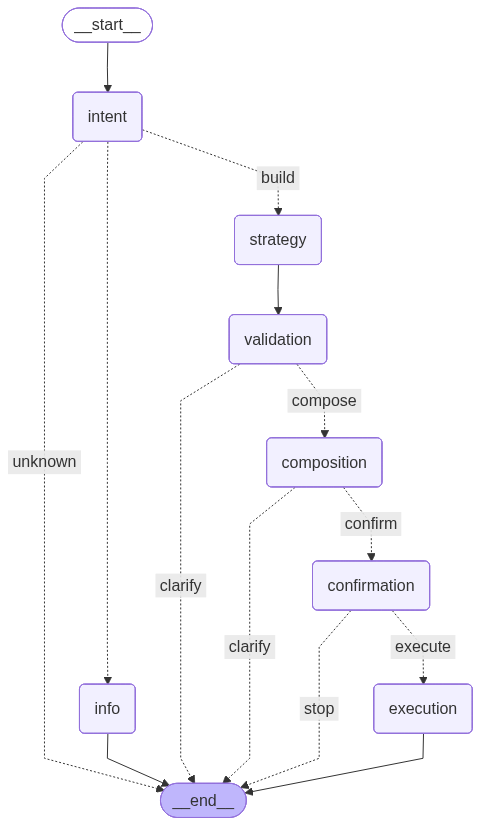

In [ ]:
Image(graph.get_graph().draw_mermaid_png())

In [11]:
import os
import sys

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

In [12]:
from core.graph.builder import build_music_graph
from session.manager import SessionManager

graph = build_music_graph(repo, sp, llm)

session = SessionManager(graph)

session.handle("Create a playlist with Drake")
session.handle("Yes")
session.handle("Add my most played songs")

{'user_input': 'Add my most played songs',
 'strategy': {'goal': 'build',
  'target': {'type': 'playlist', 'identifier': None},
  'sources': [{'type': 'top_played',
    'filters': {'timeframe': None, 'limit': None, 'name': None}}],
  'modification': {'action': None, 'parameters': {}},
  'constraints': {'max_tracks': None,
   'deduplicate': False,
   'merge_strategy': None}},
 'result_tracks': ['5WEF0icHWmAZBBMglBd599',
  '14QaXYIK3K3QPtezqxRRPN',
  '7tCuCjhxzjX2XCz4JiiAsp',
  '5WzFFWmHp3Bh9bp6MRmzdr',
  '6umI9zGUBDh0No1Sc5tHNh',
  '0Y9BzZGT2FuLVPrHoq1g2G',
  '2lTm559tuIvatlT1u0JYG2',
  '7EAMXbLcL0qXmciM5SwMh2',
  '7BRD7x5pt8Lqa1eGYC4dzj',
  '59D4DOkspUbWyMmbAPQkxZ',
  '0j2T0R9dR9qdJYsB7ciXhf',
  '017PF4Q3l4DBUiWoXk4OWT',
  '0Ryd8975WihbObpp5cPW1t',
  '0WSEq9Ko4kFPt8yo3ICd6T',
  '0d28khcov6AiegSCpG5TuT',
  '0hquQWY3xvYqN4qtiquniF',
  '152lZdxL1OR0ZMW6KquMif',
  '1797zYiX4cKosMH836X9Gt',
  '199wv1uOJYZ1XyK8FTzwh2',
  '1GfJCWGLfdev016PSsrUO8',
  '1Xm4ATvvEKx0e2GlLDmpOs',
  '1kwHrBWAlucOE5

In [10]:
session.handle("Do we have music from Dezko?")
session.handle("Create a playlist with that")

{'user_input': 'Create a playlist with that',
 'strategy': {'goal': 'build',
  'target': {'type': 'playlist', 'identifier': None},
  'sources': [],
  'modification': None,
  'constraints': {'max_tracks': None,
   'deduplicate': False,
   'merge_strategy': None}},
 'result_tracks': None,
 'error': None,
 'needs_clarification': True,
 'clarification_message': 'To build a playlist, I need at least one source.',
 'confirmed': False,
 'intent': 'build'}

In [ ]:
session.handle("Build me an airplane")

In [11]:
session.handle("Do we have music from Dezko?")

{'user_input': 'Do we have music from Dezko?',
 'strategy': None,
 'result_tracks': ['7Lqb5crtS7JaNynQ0mszWh',
  '1w8a2t4KPUD9e5Pv5uFNRP',
  '199wv1uOJYZ1XyK8FTzwh2'],
 'error': None,
 'needs_clarification': False,
 'clarification_message': 'Yes, you have 3 tracks by Dezko.',
 'confirmed': False,
 'intent': 'info'}

In [ ]:
session.handle("Create a playlist with Drake")

In [13]:
session.handle("Do we have music from Dezko?")
session.handle("Create a playlist with that")

{'user_input': 'Create a playlist with that',
 'strategy': {'goal': 'build',
  'target': {'type': 'playlist', 'identifier': None},
  'sources': [{'type': 'explicit',
    'filters': {'track_ids': ['7Lqb5crtS7JaNynQ0mszWh',
      '1w8a2t4KPUD9e5Pv5uFNRP',
      '199wv1uOJYZ1XyK8FTzwh2']}}],
  'modification': None,
  'constraints': {'max_tracks': None,
   'deduplicate': False,
   'merge_strategy': None}},
 'result_tracks': ['7Lqb5crtS7JaNynQ0mszWh',
  '1w8a2t4KPUD9e5Pv5uFNRP',
  '199wv1uOJYZ1XyK8FTzwh2'],
 'error': None,
 'needs_clarification': True,
 'clarification_message': "I found 3 tracks. Do you want me to create the playlist 'AI Generated Playlist'?",
 'confirmed': False,
 'intent': 'build'}

In [14]:
session.handle("Yes")

{'user_input': '',
 'strategy': {'goal': 'build',
  'target': {'type': 'playlist', 'identifier': None},
  'sources': [{'type': 'explicit',
    'filters': {'track_ids': ['7Lqb5crtS7JaNynQ0mszWh',
      '1w8a2t4KPUD9e5Pv5uFNRP',
      '199wv1uOJYZ1XyK8FTzwh2']}}],
  'modification': None,
  'constraints': {'max_tracks': None,
   'deduplicate': False,
   'merge_strategy': None}},
 'result_tracks': ['7Lqb5crtS7JaNynQ0mszWh',
  '1w8a2t4KPUD9e5Pv5uFNRP',
  '199wv1uOJYZ1XyK8FTzwh2'],
 'error': None,
 'needs_clarification': False,
 'clarification_message': "Playlist 'AI Generated Playlist' created successfully.",
 'confirmed': True,
 'intent': 'build'}

In [15]:
session.handle("Do we have music from Dezko?")
session.handle("Create a playlist with that")
session.handle("Yes")

{'user_input': '',
 'strategy': {'goal': 'build',
  'target': {'type': 'playlist', 'identifier': None},
  'sources': [{'type': 'explicit',
    'filters': {'track_ids': ['7Lqb5crtS7JaNynQ0mszWh',
      '1w8a2t4KPUD9e5Pv5uFNRP',
      '199wv1uOJYZ1XyK8FTzwh2']}}],
  'modification': None,
  'constraints': {'max_tracks': None,
   'deduplicate': False,
   'merge_strategy': None}},
 'result_tracks': ['7Lqb5crtS7JaNynQ0mszWh',
  '1w8a2t4KPUD9e5Pv5uFNRP',
  '199wv1uOJYZ1XyK8FTzwh2'],
 'error': None,
 'needs_clarification': False,
 'clarification_message': "Playlist 'AI Generated Playlist' created successfully.",
 'confirmed': True,
 'intent': 'build'}

In [19]:
from IPython.display import display, Markdown

diagram = """
```mermaid
flowchart TD

User --> SessionManager

SessionManager -->|invoke| LangGraph

subgraph LangGraph
    intent --> strategy --> validation --> composition --> confirmation --> execution --> END
end

confirmation -->|needs confirmation| SessionManager
SessionManager -->|reinvoke with confirmed=True| LangGraph
"""

display(Markdown(diagram))


```mermaid
flowchart TD

User --> SessionManager

SessionManager -->|invoke| LangGraph

subgraph LangGraph
    intent --> strategy --> validation --> composition --> confirmation --> execution --> END
end

confirmation -->|needs confirmation| SessionManager
SessionManager -->|reinvoke with confirmed=True| LangGraph


In [20]:
print("---- TEST 1: Basic Build ----")
r1 = session.handle("Create a playlist with Drake")
print(r1["clarification_message"])

r2 = session.handle("Yes")
print(r2["clarification_message"])

---- TEST 1: Basic Build ----
I found 13 tracks. Do you want me to create the playlist 'AI Generated Playlist'?
Playlist 'AI Generated Playlist' created successfully.


In [21]:
print("---- TEST 2: Info → Build with reference ----")
r1 = session.handle("Do we have music from Dezko?")
print(r1["clarification_message"])

r2 = session.handle("Create a playlist with that")
print(r2["clarification_message"])

r3 = session.handle("Yes")
print(r3["clarification_message"])

---- TEST 2: Info → Build with reference ----
Yes, you have 3 tracks by Dezko.
I found 3 tracks. Do you want me to create the playlist 'AI Generated Playlist'?
Playlist 'AI Generated Playlist' created successfully.


In [22]:
print("---- TEST 3: Unknown ----")
r = session.handle("Build me a spaceship")
print(r["intent"], r["clarification_message"])

---- TEST 3: Unknown ----
unknown None


In [23]:
print(session.context.phase)

SessionPhase.IDLE


In [24]:
print("---- TEST 4: Modify Add ----")

r1 = session.handle("Create a playlist with Drake")
session.handle("Yes")

r2 = session.handle("Add my most played songs to AI Generated Playlist")
print(r2["clarification_message"])

r3 = session.handle("Yes")
print(r3["clarification_message"])

---- TEST 4: Modify Add ----
I found 78 tracks to add to 'AI Generated Playlist'. Do you want me to proceed?
78 tracks added to 'AI Generated Playlist'.


In [25]:
print("---- TEST 5: Orphan Yes ----")
r = session.handle("Yes")
print(r)

---- TEST 5: Orphan Yes ----
{'user_input': 'Yes', 'strategy': None, 'result_tracks': None, 'error': None, 'needs_clarification': False, 'clarification_message': None, 'confirmed': False, 'intent': 'unknown'}


In [26]:
session.context.last_interaction_ts = session.context.last_interaction_ts.replace(year=2000)
r = session.handle("Create a playlist with Drake")
print(session.context.phase)

SessionPhase.WAITING_CONFIRMATION
